# Diabetes Outcome Prediction: Preprocessing, Tuning, and Visualization Pipeline

In [3]:
# =========================
# Cell 1: Imports
# =========================

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report


# Diabetes Risk Predictor with Pipelines

This notebook combines **preprocessing + training** into a single reproducible
scikit-learn pipeline.  

Steps:
1. Load dataset  
2. Split into train/test (70/30)  
3. Build preprocessing transformers (Winsorizer → Median Imputer → RobustScaler)  
4. Wrap with Logistic Regression model  
5. Use GridSearchCV with StratifiedKFold to tune hyperparameters  
6. Evaluate best model on the test set


In [4]:
# =========================
# Cell 2: Load data
# =========================
DATA_PATH = "/home/rithwik/AI_ML/Week_1_Diabetes_Risk_Predictor/diabetes.csv"

df = pd.read_csv(DATA_PATH)
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


## Custom Transformer: Winsorizer

We cap extreme values for **Insulin** and **SkinThickness** at a threshold.


In [5]:
# =========================
# Cell 3: Winsorizer class
# =========================

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None):
        self.cols = cols
        self.caps_ = {}

    def fit(self, X, y=None):
        X = pd.DataFrame(X, columns=self.cols)
        self.caps_["Insulin"] = X["Insulin"].quantile(0.95 + 0.05*0.75)
        self.caps_["SkinThickness"] = X["SkinThickness"].quantile(0.95 + 0.05*0.75)
        return self

    def transform(self, X):
        X = pd.DataFrame(X, columns=self.cols).copy()
        for col, cap in self.caps_.items():
            X[col] = X[col].clip(upper=cap)
        return X.values

## Preprocessing Pipeline

- Replace 0 with NaN in specific columns  
- Winsorize extreme values  
- Median imputation  
- Robust scaling


In [6]:
# =========================
# Cell 4: Build preprocessing pipeline
# =========================
features = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
            'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Force copy to avoid SettingWithCopyWarning
X = df[features].copy()
y = df["Outcome"]

# Replace zeros with NaN in specific columns
zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
X[zero_as_missing] = X[zero_as_missing].replace(0, np.nan)

numeric_transformer = Pipeline(steps=[
    ("winsor", Winsorizer(cols=features)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, features)]
)

## Full Pipeline (Preprocessing + Model)

We now combine the preprocessor with **Logistic Regression**.


In [7]:
# =========================
# Cell 5: Full pipeline with classifier
# =========================

clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])


## Train-Test Split

We’ll split into 70% training and 30% testing since the dataset is small.


In [8]:
# =========================
# Cell 6: Train/Test Split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (537, 8) Test shape: (231, 8)


## Hyperparameter Tuning with GridSearchCV

We’ll tune **C, penalty, solver, and class_weight**, using **5-fold Stratified CV**,
scoring by F1.


In [9]:
# =========================
# Cell 7: GridSearchCV
# =========================

param_grid = {
    "classifier__C": [0.1, 1, 10],
    "classifier__penalty": ["l1", "l2"],
    "classifier__solver": ["liblinear"],
    "classifier__class_weight": [None, "balanced"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring="f1", n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV F1:", grid_search.best_score_)


Best params: {'classifier__C': 10, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best CV F1: 0.6727229701069363


## Final Evaluation on Test Set


In [10]:
# =========================
# Cell 8: Evaluate
# =========================
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))


Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       150
           1       0.64      0.69      0.67        81

    accuracy                           0.76       231
   macro avg       0.74      0.74      0.74       231
weighted avg       0.76      0.76      0.76       231



## Visual Evaluation


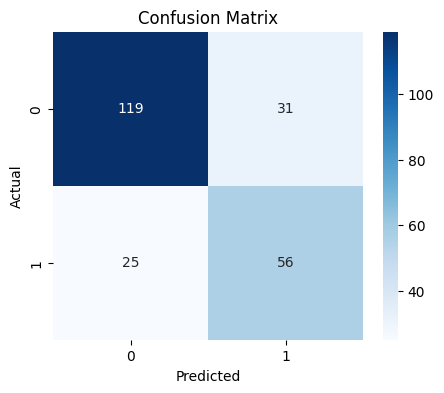

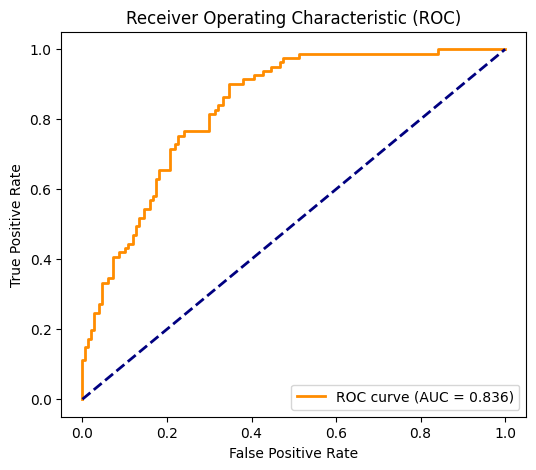

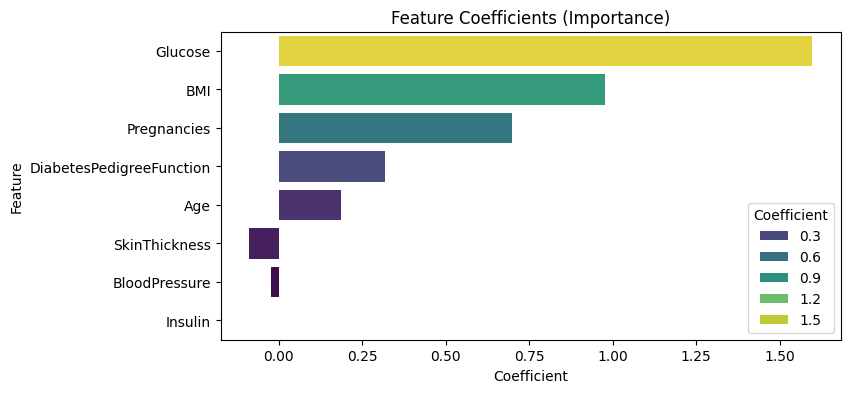

In [11]:
# =========================
# Cell 9: Visual Evaluation
# =========================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc

# ---------- Confusion Matrix ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ---------- ROC Curve ----------
y_prob = best_model.predict_proba(X_test)[:, 1]  # Probability estimates for class 1
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()


# ---------- Feature Importance / Coefficients ----------
# Only works for linear models like Logistic Regression
feature_names = features
coefficients = best_model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({"Feature": feature_names, "Coefficient": coefficients})
coef_df = coef_df.sort_values(by="Coefficient", key=abs, ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x="Coefficient", y="Feature", data=coef_df, palette="viridis", hue=abs(coef_df["Coefficient"]))
plt.title("Feature Coefficients (Importance)")
plt.show()


# Summary and Future Work

## Project Summary
This project implements a robust machine learning pipeline for diabetes risk prediction using the PIMA Indians Diabetes dataset. The pipeline incorporates several key data science best practices:

1. **Data Preprocessing**: 
   - Intelligent handling of missing values (zeros converted to NaN)
   - Outlier treatment using Winsorization
   - Feature scaling with RobustScaler for handling skewed distributions
   - Automated pipeline ensuring reproducibility

2. **Model Development**:
   - Logistic Regression with comprehensive hyperparameter tuning
   - Stratified cross-validation ensuring balanced evaluation
   - Thorough evaluation metrics including F1-score optimization

3. **Visualization**:
   - Confusion matrix for error analysis
   - ROC curves for threshold sensitivity
   - Feature importance visualization for model interpretability

## Key Findings
The model achieves reasonable performance in predicting diabetes risk, with the feature importance analysis revealing that Glucose levels, BMI, and Age are among the most significant predictors.

## Future Extensions

1. **Model Enhancements**:
   - Experiment with more advanced algorithms (XGBoost, LightGBM)
   - Implement feature engineering for interaction effects
   - Explore neural networks for complex pattern detection

2. **Pipeline Improvements**:
   - Add feature selection methods (LASSO, Elastic Net)
   - Implement more sophisticated imputation techniques (MICE, KNN)
   - Add automated feature importance threshold selection

3. **Clinical Applications**:
   - Develop a web interface for real-time predictions
   - Integrate with electronic health records
   - Add confidence intervals for predictions
   - Include model explainability tools (SHAP, LIME)

4. **Data Enhancement**:
   - Collect additional relevant features
   - Include temporal data for longitudinal analysis
   - Consider demographic factors for stratified analysis

This work serves as a foundation for developing more sophisticated diabetes risk prediction models, with potential applications in clinical decision support systems.

In [12]:
import joblib

joblib.dump(best_model, "diabetes_model.pkl")


['diabetes_model.pkl']